In [153]:
import astropy
from astropy.io import fits as FF
import numpy as np
from pylab import *

from skimage import data, color
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.feature import canny
from skimage.draw import circle_perimeter
from skimage.util import img_as_ubyte
from skimage import data, io, filters
from skimage.feature import match_template
from skimage.feature import peak_local_max




In [83]:
data = [2528, 2534]
darks = [2535, 2541]
flats = [2544, 2550]

In [84]:
def to_filenames(rr):
    """ Convert a range rr of [start, stop] to a list of filenames """
    
    nms = []
    for i in range(*rr):
        nms.append(f"lvm.spec.agcam.east_{i:08}.fits")

    return nms
        

In [85]:
def msd(data):
    return np.mean(data), np.std(data)

In [86]:
def comb(files):
    
    stack = []
    for name in files:
        f = FF.open(name)
        dat = f[0].data
        mn,sd = msd(dat)
        print(f"{name}: {mn:1.3} {sd:1.3}")
        
        stack.append(dat)
    return np.median(np.array(stack), axis=0)

In [95]:

c = comb(to_filenames(data))
print("---")
bgd = comb(to_filenames(darks))
print("---")
flat = comb(to_filenames(flats))
flat /= np.median(flat-bgd/5)

dat = (c-bgd)/(flat)

out = FF.PrimaryHDU(dat)
out.writeto("cleaned.fits", overwrite=True)

lvm.spec.agcam.east_00002528.fits: 3.18e+04 1.84e+04
lvm.spec.agcam.east_00002529.fits: 3.18e+04 1.84e+04
lvm.spec.agcam.east_00002530.fits: 3.14e+04 1.83e+04
lvm.spec.agcam.east_00002531.fits: 3.12e+04 1.82e+04
lvm.spec.agcam.east_00002532.fits: 3.14e+04 1.83e+04
lvm.spec.agcam.east_00002533.fits: 3.16e+04 1.84e+04
---
lvm.spec.agcam.east_00002535.fits: 1.82e+02 2.03e+02
lvm.spec.agcam.east_00002536.fits: 1.79e+02 2.03e+02
lvm.spec.agcam.east_00002537.fits: 1.79e+02 2.03e+02
lvm.spec.agcam.east_00002538.fits: 1.79e+02 2.03e+02
lvm.spec.agcam.east_00002539.fits: 1.79e+02 2.03e+02
lvm.spec.agcam.east_00002540.fits: 1.79e+02 2.03e+02
---
lvm.spec.agcam.east_00002544.fits: 1.67e+04 4.04e+03
lvm.spec.agcam.east_00002545.fits: 1.66e+04 4.03e+03
lvm.spec.agcam.east_00002546.fits: 1.66e+04 4.03e+03
lvm.spec.agcam.east_00002547.fits: 1.66e+04 4.03e+03
lvm.spec.agcam.east_00002548.fits: 1.66e+04 4.03e+03
lvm.spec.agcam.east_00002549.fits: 1.66e+04 4.03e+03


In [123]:
edges = filters.sobel(dat)

(700.0, 800.0)

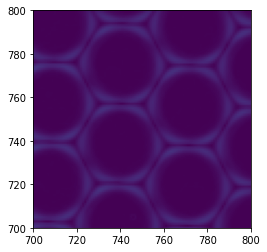

In [126]:
imshow(edges)
xlim(700, 800)
ylim(700,800)

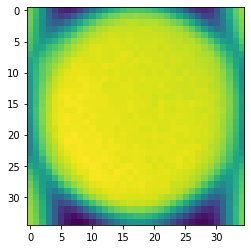

In [142]:
template = dat[740:775, 755:790]
imshow(template)

In [182]:
?match_template

In [183]:
res = match_template(dat, template, pad_input=True)

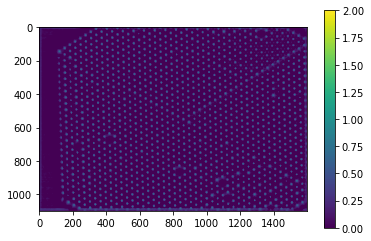

In [185]:
imshow(res,vmin=0, vmax=2)
colorbar()

In [406]:
pks = peak_local_max(res, min_distance=12, threshold_abs=.7)
x,y = pks.T
pks.shape

(1322, 2)

(600.0, 800.0)

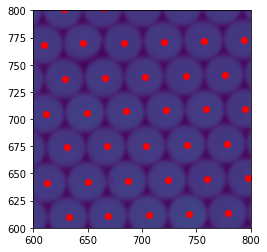

In [407]:
imshow(dat.T)
plot(x,y,'or')
xlim(600,800)
ylim(600,800)

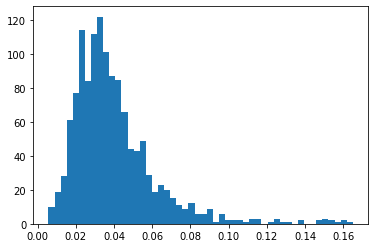

In [428]:
R = 17
off = 0
metrics = []
for i in range(len(pks)):
    x,y = pks[i+off]

    sl = (slice(x-R, x+R), slice(y-R, y+R))
    slf = (slice(x+R, x-R,-1), slice(y+R, y-R, -1))


    try: 
        top = np.percentile(dat[sl], 95)
        metrics.append(np.median(np.abs(dat[sl] - dat[slf])/top))
        
    except: continue
            
metrics = np.array(metrics)
hist(metrics,50);


In [429]:
np.sqrt(1300)

36.05551275463989

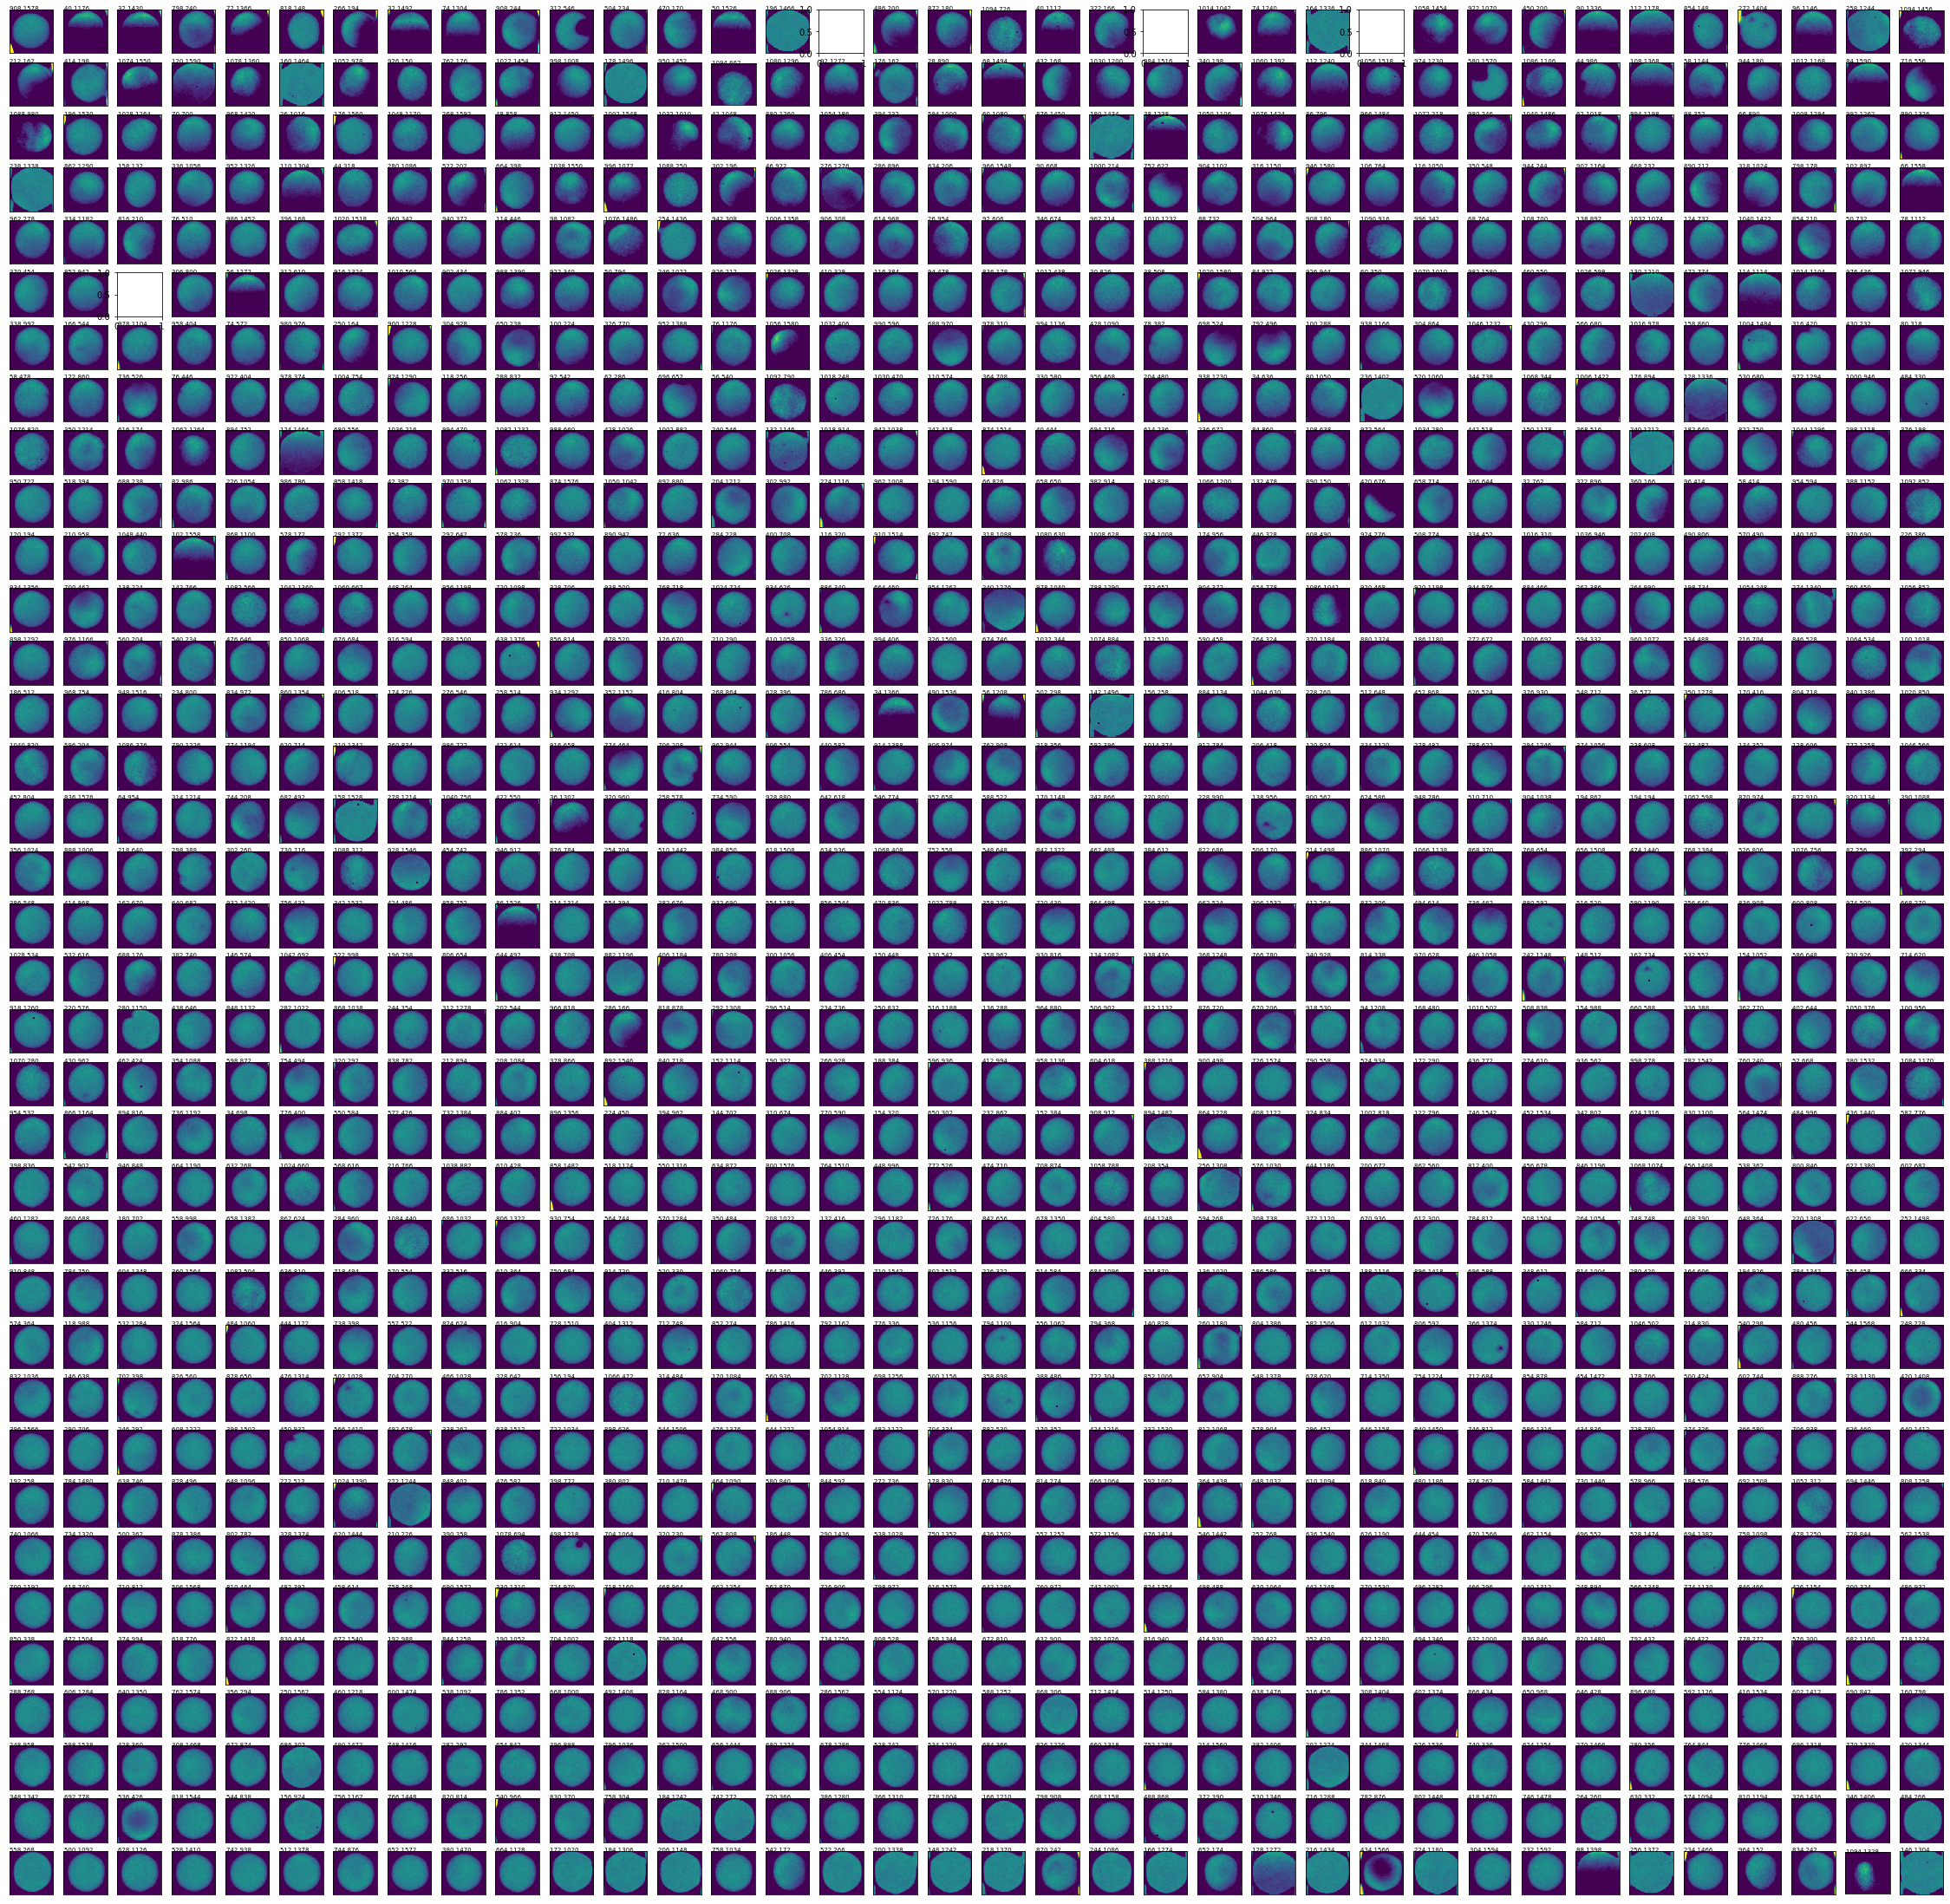

In [453]:
N = 36
figure(figsize=(40,40))
subplot(N,N,1)
R = 17

order = np.flip(np.argsort(metrics))

def fmt_txt(x,y,R):
    
    return f"{x+R/2:.0f} {y+R/2:.0f}"

syms = []
for i in range(N*N):
    x,y = pks[order[i]]
    

    #print(metrics[order][i])

    sl = (slice(x-R, x+R), slice(y-R, y+R))
    subplot(N,N,i+1)
    

    try: top = np.percentile(dat[sl], [95])
    except: continue
    fig = imshow(dat[sl], vmin=0.9*top, vmax =top*1.1)
    
    #fig.set_cmap('hot')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    
    txt = fmt_txt(x,y,R)
    text(0,0,txt, fontsize="x-small")


savefig("4-mar-2023-sci-spec-selfie-top10percent.pdf")
#tight_layout()

In [441]:
fmt_txt(x,y,R)

'146.5 1304.5'

In [451]:
f"{x+R/2:.0f}"

'146'

In [326]:
syms

[]